### 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import psycopg2
from geopy.distance import great_circle
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt    

### 2. Data Extraction Function

In [2]:
def extract_data(user_limit=5000, lower_percentile=0.50, upper_percentile=0.95):
    conn = psycopg2.connect(
        dbname="gisdb",
        user="postgres",
        password="task4TH",
        host="localhost"
    )

    query = f"""
    WITH user_log_count AS (
    SELECT uuid, COUNT(*) AS log_count
    FROM blogwatcher.gps_logs
    WHERE logtime BETWEEN '2023-08-07' AND '2023-08-20'
    GROUP BY uuid
    ),
    percentiles AS (
        SELECT
            PERCENTILE_CONT({lower_percentile}) WITHIN GROUP (ORDER BY log_count) AS lower_bound,
            PERCENTILE_CONT({upper_percentile}) WITHIN GROUP (ORDER BY log_count) AS upper_bound
        FROM user_log_count
    ),
    selected_users AS (
        SELECT uuid
        FROM user_log_count, percentiles
        WHERE log_count BETWEEN lower_bound AND upper_bound
    )
    SELECT 
        gps_logs.uuid,  
        gps_logs.logtime, 
        gps_logs.accuracy, 
        gps_logs.ios, 
        ST_AsText(gps_logs.geom) AS geom
    FROM blogwatcher.gps_logs gps_logs
    JOIN selected_users su ON gps_logs.uuid = su.uuid
    WHERE gps_logs.logtime BETWEEN '2023-08-07' AND '2023-08-20'
    ORDER BY gps_logs.uuid, gps_logs.logtime;
    """

    gps_data = pd.read_sql(query, conn)
    conn.close()

    unique_users = gps_data['uuid'].unique()
    if len(unique_users) > user_limit:
        selected_users = np.random.choice(unique_users, user_limit, replace=False)
        gps_data = gps_data[gps_data['uuid'].isin(selected_users)]

    print(f"Selected {len(gps_data['uuid'].unique())} users for analysis.")
    return gps_data
    

### 3. Stay Points, Radius of Gyration, and Jump Length Calculations

#### a) Stay Points Identification

In [3]:
def identify_stay_points(gps_data, epsilon=100, min_samples=2, time_threshold=600, revisit_time_gap=1800):
    all_stay_points = []

    # Group by uuid and date
    for (uuid, date), user_data in gps_data.groupby([gps_data['uuid'], gps_data['logtime'].dt.date]):
        coords = user_data[['latitude', 'longitude']].to_numpy()
        db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(coords)
        user_data['cluster'] = db.labels_

        stay_points = []
        for cluster_id in set(user_data['cluster']):
            if cluster_id == -1:
                continue
            cluster_points = user_data[user_data['cluster'] == cluster_id].sort_values(by='logtime').copy()
            cluster_points['time_diff'] = (cluster_points['logtime'] - cluster_points['logtime'].shift()).dt.total_seconds()
            visit_id = 0
            for idx, row in cluster_points.iterrows():
                if pd.isnull(row['time_diff']) or row['time_diff'] > revisit_time_gap:
                    visit_id += 1
                cluster_points.at[idx, 'visit_id'] = visit_id

            for visit_id, visit_points in cluster_points.groupby('visit_id'):
                stay_duration = (visit_points['logtime'].max() - visit_points['logtime'].min()).total_seconds()
                if stay_duration >= time_threshold:
                    stay_lat = visit_points['latitude'].mean()
                    stay_lon = visit_points['longitude'].mean()
                    stay_start_time = visit_points['logtime'].min()
                    stay_end_time = visit_points['logtime'].max()
                    stay_points.append({
                        'uuid': uuid,
                        'date': date,
                        'latitude': stay_lat,
                        'longitude': stay_lon,
                        'start_time': stay_start_time,
                        'end_time': stay_end_time,
                        'duration': stay_duration
                    })
        all_stay_points.extend(stay_points)
    
    return pd.DataFrame(all_stay_points)

#### b) Radius of Gyration Calculation

In [13]:
def calculate_radius_of_gyration(gps_data):
    all_radius_of_gyration = []

    # Group by uuid and date
    for (uuid, date), user_data in gps_data.groupby([gps_data['uuid'], gps_data['logtime'].dt.date]):
        lat_lon_center = user_data[['latitude', 'longitude']].mean().values
        user_data['dist_from_center'] = user_data.apply(
            lambda row: great_circle(lat_lon_center, (row['latitude'], row['longitude'])).meters, axis=1
        )
        radius_of_gyration = np.sqrt((user_data['dist_from_center'] ** 2).mean())
        all_radius_of_gyration.append({
            'uuid': uuid,
            'date': date,
            'radius_of_gyration': radius_of_gyration
        })

    return pd.DataFrame(all_radius_of_gyration)

#### c) Jump Length Calculation

In [5]:
def calculate_jump_lengths(gps_data, distance_threshold=100, time_threshold=3600):
    all_jump_lengths = []

    # Group by uuid and date
    for (uuid, date), user_data in gps_data.groupby([gps_data['uuid'], gps_data['logtime'].dt.date]):
        user_data = user_data.sort_values(by='logtime')
        user_data['next_latitude'] = user_data['latitude'].shift(-1)
        user_data['next_longitude'] = user_data['longitude'].shift(-1)
        user_data['time_diff'] = (user_data['logtime'].shift(-1) - user_data['logtime']).dt.total_seconds()

        jump_lengths = []
        for _, row in user_data.iterrows():
            if row['time_diff'] is not None and row['time_diff'] <= time_threshold:
                distance = great_circle(
                    (row['latitude'], row['longitude']), 
                    (row['next_latitude'], row['next_longitude'])
                ).meters
                if distance >= distance_threshold:
                    jump_lengths.append({
                        'uuid': uuid,
                        'date': date,
                        'jump_length': distance
                    })
        all_jump_lengths.extend(jump_lengths)
    
    return pd.DataFrame(all_jump_lengths)

### 4. Visualization Functions

In [23]:
def plot_jump_length_by_date(jump_lengths_df, bin_min=1, bin_max=5000, num_bins=50):
    """
    Plot jump length distributions for each date on the same plot.
    
    Parameters:
        jump_lengths_df (DataFrame): DataFrame with jump lengths data, including 'jump_length' and 'date'.
        bin_min (float): Minimum value for histogram bins.
        bin_max (float): Maximum value for histogram bins.
        num_bins (int): Number of bins for the histogram.
    """
    plt.figure(figsize=(12, 8))
    
    # Group data by date and plot each date's distribution
    for date, group in jump_lengths_df.groupby('date'):
        hist, bin_edges = np.histogram(
            group['jump_length'], bins=np.logspace(np.log10(bin_min), np.log10(bin_max), num_bins), density=True
        )
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        hist = np.where(hist == 0, np.nan, hist)

        plt.plot(bin_centers, hist, '-o', markersize=4, label=str(date))
    
    # Configure plot aesthetics
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Jump Length (meters)', fontsize=16)
    plt.ylabel('P(Jump Length)', fontsize=16)
    plt.title('Jump Length Distribution by Date', fontsize=18)
    plt.grid(True, which="both", ls="--")
    plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


def plot_stay_duration_by_date(stay_points_df, bin_min=1, bin_max=86400, num_bins=50):
    """
    Plot stay duration distributions for each date on the same plot.
    
    Parameters:
        stay_points_df (DataFrame): DataFrame with stay points data, including 'duration' and 'date'.
        bin_min (float): Minimum value for histogram bins.
        bin_max (float): Maximum value for histogram bins.
        num_bins (int): Number of bins for the histogram.
    """
    plt.figure(figsize=(12, 8))
    
    # Group data by date and plot each date's distribution
    for date, group in stay_points_df.groupby('date'):
        hist, bin_edges = np.histogram(
            group['duration'], bins=np.logspace(np.log10(bin_min), np.log10(bin_max), num_bins), density=True
        )
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        hist = np.where(hist == 0, np.nan, hist)  # Replace 0s with NaN for cleaner interpolation

        plt.plot(bin_centers, hist, '-o', markersize=4, label=str(date))
    
    # Configure plot aesthetics
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Stay Duration (seconds)', fontsize=16)
    plt.ylabel('P(Stay Duration)', fontsize=16)
    plt.title('Stay Duration Distribution by Date', fontsize=18)
    plt.grid(True, which="both", ls="--")
    plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


def plot_radius_of_gyration_by_date(radius_of_gyration_df, bin_min=1, bin_max=10000, num_bins=50):
    """
    Plot radius of gyration distributions for each date on the same plot.
    
    Parameters:
        radius_of_gyration_df (DataFrame): DataFrame with radius of gyration data, including 'radius_of_gyration' and 'date'.
        bin_min (float): Minimum value for histogram bins.
        bin_max (float): Maximum value for histogram bins.
        num_bins (int): Number of bins for the histogram.
    """
    plt.figure(figsize=(12, 8))
    
    # Group data by date and plot each date's distribution
    for date, group in radius_of_gyration_df.groupby('date'):
        hist, bin_edges = np.histogram(
            group['radius_of_gyration'], bins=np.logspace(np.log10(bin_min), np.log10(bin_max), num_bins), density=True
        )
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        hist = np.where(hist == 0, np.nan, hist)  # Replace 0s with NaN for cleaner interpolation

        plt.plot(bin_centers, hist, '-o', markersize=4, label=str(date))
    
    # Configure plot aesthetics
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Radius of Gyration (meters)', fontsize=16)
    plt.ylabel('P(Radius of Gyration)', fontsize=16)
    plt.title('Radius of Gyration Distribution by Date', fontsize=18)
    plt.grid(True, which="both", ls="--")
    plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

### 5. Main Program

In [7]:
%%time
# Step 1: Data Extraction
gps_data = extract_data(user_limit=1000, lower_percentile=0.50, upper_percentile=0.95)

/tmp/ipykernel_6781/3438335637.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  gps_data = pd.read_sql(query, conn)


Selected 1000 users for analysis.
CPU times: user 5min 48s, sys: 1min 12s, total: 7min
Wall time: 16min 38s


In [25]:
%%time
# Step 1: Data Extraction
gps_data = extract_data(user_limit=30000, lower_percentile=0.50, upper_percentile=0.95)

/tmp/ipykernel_6781/3438335637.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  gps_data = pd.read_sql(query, conn)


Selected 30000 users for analysis.
CPU times: user 5min 59s, sys: 1min 2s, total: 7min 2s
Wall time: 17min 37s


In [26]:
gps_data[['longitude', 'latitude']] = gps_data['geom'].str.extract(r'POINT\(([^ ]+) ([^ ]+)\)').astype(float)
gps_data = gps_data[gps_data['accuracy']<80]
gps_data

,uuid,logtime,accuracy,ios,geom,longitude,latitude
37090,0006b23f-eb8e-e66a-380f-f1638756d1eb,2023-08-07 02:03:39,5.320,True,POINT(139.3271545 35.6588921),139.327155,35.658892
37091,0006b23f-eb8e-e66a-380f-f1638756d1eb,2023-08-08 10:53:27,5.410,True,POINT(139.3271576 35.658895),139.327158,35.658895
37092,0006b23f-eb8e-e66a-380f-f1638756d1eb,2023-08-08 10:53:28,5.410,True,POINT(139.3271597 35.6588926),139.327160,35.658893
37093,0006b23f-eb8e-e66a-380f-f1638756d1eb,2023-08-08 10:53:41,5.410,True,POINT(139.3271576 35.6588933),139.327158,35.658893
37094,0006b23f-eb8e-e66a-380f-f1638756d1eb,2023-08-08 10:53:52,5.410,True,POINT(139.3271573 35.6588945),139.327157,35.658895
...,...,...,...,...,...,...,...
394847275,ffff6746-ba44-7847-8566-65162d6f07a7,2023-08-19 19:41:27,42.500,False,POINT(139.7106358 35.7302964),139.710636,35.730296
394847277,ffff6746-ba44-7847-8566-65162d6f07a7,2023-08-19 19:53:54,16.089,False,POINT(139.6936259 35.7565231),139.693626,35.756523
394847278,ffff6746-ba44-7847-8566-65162d6f07a7,2023-08-19 19:57:55,16.089,False,POINT(139.6936259 35.7565231),139.693626,35.756523
394847279,ffff6746-ba44-7847-8566-65162d6f07a7,2023-08-19 19:59:57,21.469,False,POINT(139.6641371 35.7683273),139.664137,35.768327


In [27]:
%%time
# Step 2: Stay Points Identification
stay_points_df = identify_stay_points(gps_data)
print(stay_points_df.head())

                                   uuid        date   latitude   longitude  \
0  0006b23f-eb8e-e66a-380f-f1638756d1eb  2023-08-08  35.658891  139.327168   
1  0006b23f-eb8e-e66a-380f-f1638756d1eb  2023-08-08  35.658893  139.327160   
2  0006b23f-eb8e-e66a-380f-f1638756d1eb  2023-08-08  35.658895  139.327158   
3  0006b23f-eb8e-e66a-380f-f1638756d1eb  2023-08-09  35.658896  139.327159   
4  0006b23f-eb8e-e66a-380f-f1638756d1eb  2023-08-16  35.658882  139.327155   

           start_time            end_time  duration  
0 2023-08-08 10:53:27 2023-08-08 11:16:17    1370.0  
1 2023-08-08 15:17:29 2023-08-08 15:29:19     710.0  
2 2023-08-08 20:45:38 2023-08-08 21:38:09    3151.0  
3 2023-08-09 07:01:33 2023-08-09 07:13:11     698.0  
4 2023-08-16 21:39:36 2023-08-16 21:54:25     889.0  
CPU times: user 5h 39min 49s, sys: 7min 57s, total: 5h 47min 47s
Wall time: 18min 28s


In [28]:
%%time
# Step 3: Radius of Gyration Calculation
radius_of_gyration_df = calculate_radius_of_gyration(gps_data)
print(radius_of_gyration_df.head())

                                   uuid        date  radius_of_gyration
0  0006b23f-eb8e-e66a-380f-f1638756d1eb  2023-08-07            0.000000
1  0006b23f-eb8e-e66a-380f-f1638756d1eb  2023-08-08            0.903097
2  0006b23f-eb8e-e66a-380f-f1638756d1eb  2023-08-09            0.243276
3  0006b23f-eb8e-e66a-380f-f1638756d1eb  2023-08-16            0.608385
4  0006b23f-eb8e-e66a-380f-f1638756d1eb  2023-08-17            0.344370
CPU times: user 4min 2s, sys: 32.5 ms, total: 4min 2s
Wall time: 4min 12s


In [29]:
%%time
# Step 4: Jump Length Calculation
jump_lengths_df = calculate_jump_lengths(gps_data)
print(jump_lengths_df.head())

                                   uuid        date  jump_length
0  00128b6a-2219-3ae0-5a29-ba069f8e5c1a  2023-08-16  1190.420780
1  00128b6a-2219-3ae0-5a29-ba069f8e5c1a  2023-08-16  2862.307428
2  00128b6a-2219-3ae0-5a29-ba069f8e5c1a  2023-08-16  1783.842128
3  00128b6a-2219-3ae0-5a29-ba069f8e5c1a  2023-08-16   302.157955
4  00128b6a-2219-3ae0-5a29-ba069f8e5c1a  2023-08-16  2066.407021
CPU times: user 7min 36s, sys: 41.8 ms, total: 7min 36s
Wall time: 7min 56s


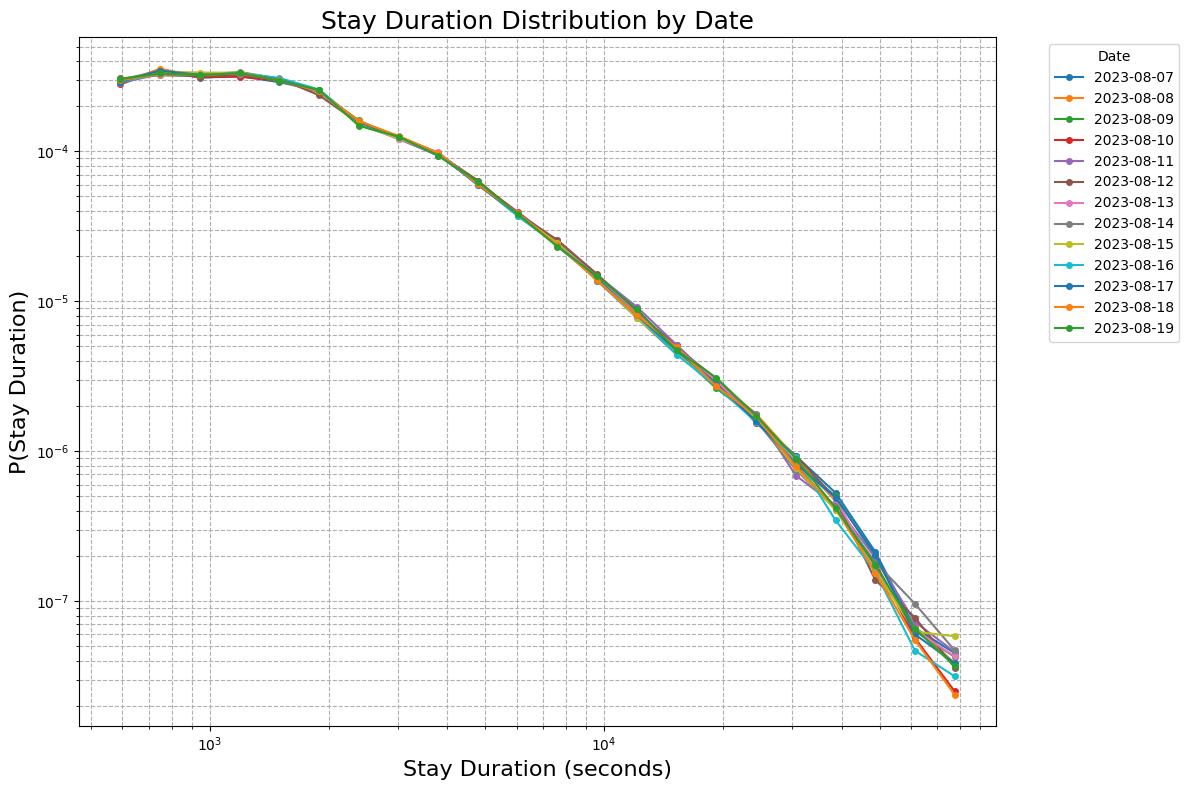

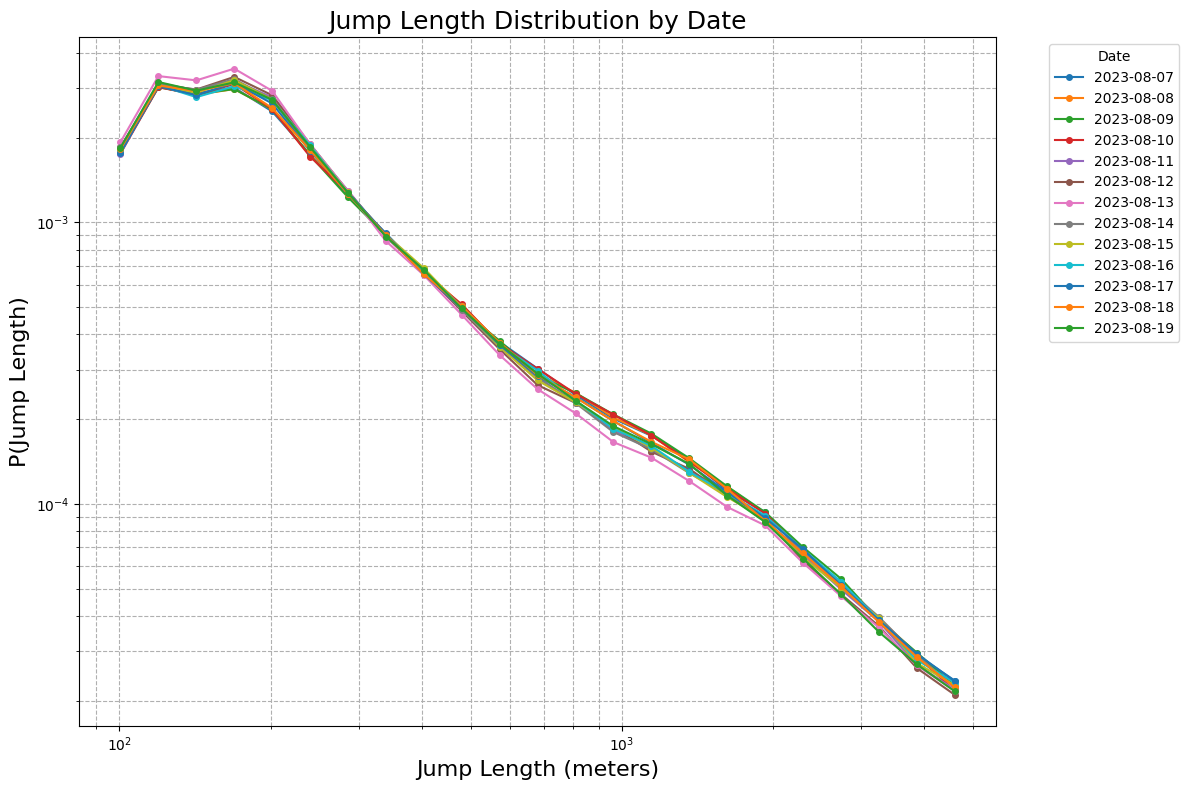

/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


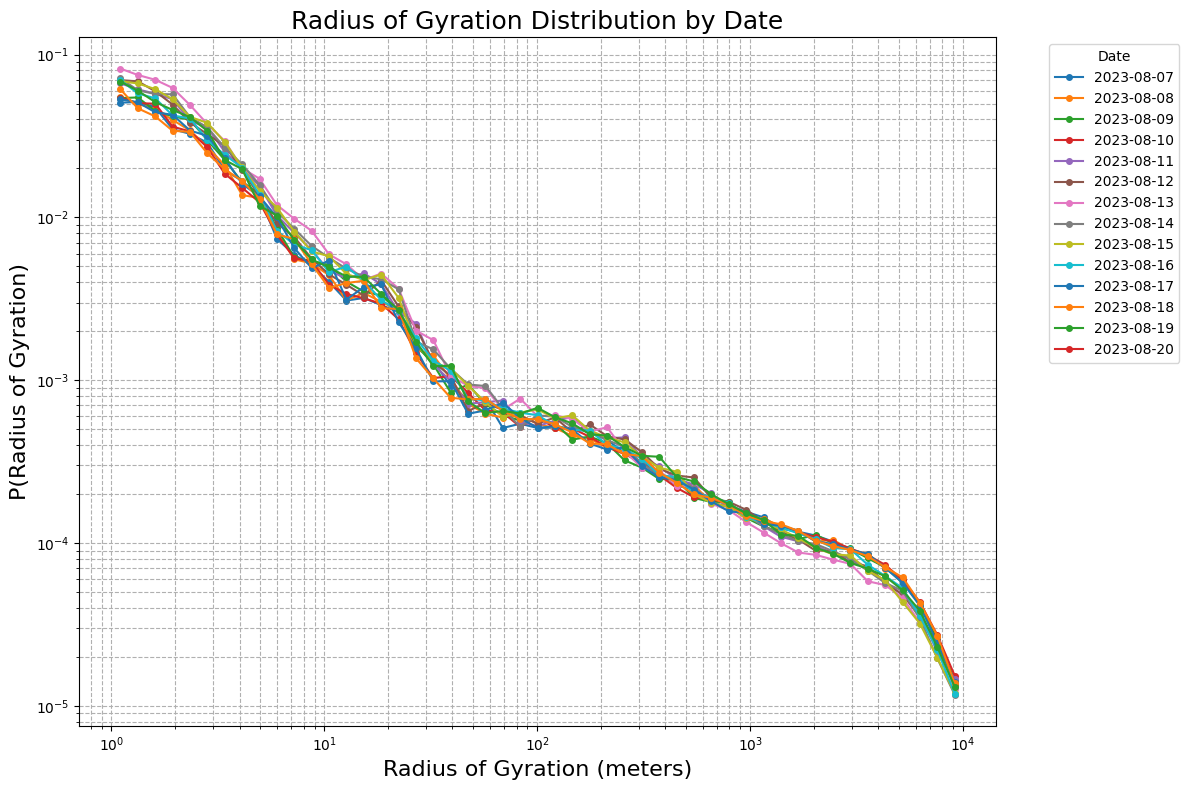

In [30]:
# Step 5: Data Visualization
plot_stay_duration_by_date(stay_points_df)

plot_jump_length_by_date(jump_lengths_df)

plot_radius_of_gyration_by_date(radius_of_gyration_df)

In [31]:
import folium

# Define the center of the map based on the extent coordinates' average
map_center = [(24.2846204 + 35.8932032) / 2, (138.9426085 + 153.9813445) / 2]

# Create a folium map centered on the average of the extent's coordinates
m = folium.Map(location=map_center, zoom_start=5)

# Define the extent as a list of (latitude, longitude) tuples for folium
extent_coords = [
    (24.2846204, 138.9426085),
    (35.8932032, 138.9426085),
    (35.8932032, 153.9813445),
    (24.2846204, 153.9813445),
    (24.2846204, 138.9426085)  # Close the polygon
]

# Add the extent polygon to the map
folium.Polygon(locations=extent_coords, color='blue', fill=True, fill_opacity=0.2, weight=2).add_to(m)

# Display the map in a Jupyter Notebook or save it as HTML
m.save("extent_map.html")
m
